Debugging variance of GKP via SMSV, parallel to GKP at some point but now defunct

## Set-up

Imports

In [2]:
%load_ext autoreload
%autoreload 2
%autosave 60

import strawberryfields as sf
from qutip import wigner

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colors, colorbar, colormaps
import matplotlib.ticker as tkr

mpl.rcParams["mathtext.fontset"] = "cm"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["lines.linewidth"] = 2
plt.rcParams.update({"font.size": 18})

π = np.pi
vacuum_FWHM = 2 * np.sqrt(2 * np.log(2)) * np.sqrt(0.5)

import sys, os

# include parent directory in import path
sys.path.insert(1, os.path.join(os.getcwd(), "../python_source"))
sys.path.insert(1, os.path.join(os.getcwd(), "../scripts"))

from operators import *
from states import *
from loss_channels import *
from encoding_channels import *
from fisher_information import *
from plotters import *
from variational_algorithm import *
from QFIM_SMSV import *

import scipy
import pandas as pd
from tqdm.notebook import tqdm
from glob import glob
from pathlib import Path

Autosaving every 60 seconds


Methods

In [3]:
def smsv_r_from_variance(variance0):
    """Var[x] = e^-2r / 2, Var[p] = e^2r / 2"""
    return -np.log(2 * variance0) / 2  # = r


def smsv_r_from_stdev(stdev0):
    return smsv_r_from_variance(stdev0**2)


def lossy_UB_Tuvia(σ, η_input, nbar):
    """UB on the ECQFI at nbar"""
    fraction_Tuvia = lambda xSqr: xSqr / ((1 - η_input) + 2 * η_input * xSqr)
    lossy_UB_Tuvia_xSqr = (
        lambda xSqr: 4 * fraction_Tuvia(xSqr) / (1 + 2 * fraction_Tuvia(xSqr) * σ**2)
    )

    # converting xSqr (really, here, pSqr) to nBar in the same way as SMSV
    xSqr_SMSV = nbar + 0.5 + np.sqrt(nbar * (1 + nbar))
    return lossy_UB_Tuvia_xSqr(xSqr_SMSV)


def marginals(W, xvec, pvec):
    margs = dict()

    # integral along p
    Δx = xvec[1] - xvec[0]
    margs["x"] = np.sum(Δx * W, axis=0)

    # integral along x
    Δp = pvec[1] - pvec[0]
    margs["p"] = np.sum(Δp * W, axis=0)

    # norm
    margs["norm"] = np.sum(Δp * margs["x"])

    return margs

Style

In [4]:
# Bang Wong color blind--friendly colours
COLOURS = {
    "Black": "#000000",
    "Orange": "#E69F00",
    "Sky blue": "#56B4E9",
    "Bluish green": "#009E73",
    "Yellow": "#F0E442",
    "Blue": "#0072B2",
    "Vermillion": "#D55E00",
    "Reddish purple": "#CC79A7",
}


def grid(ax):
    ax.grid("both", "both", color="gainsboro", zorder=0)


def legend(ax, reversed=False, **kwargs):
    defaults = dict(handlelength=1, labelspacing=0, frameon=False, handletextpad=0.3)
    if reversed:
        h, l = ax.get_legend_handles_labels()
        ax.legend(handles=reversed(h), labels=reversed(l), **(defaults | kwargs))
    else:
        ax.legend(**(defaults | kwargs))


def colorbar_without_resizing(fig, ax, image, pad=0.05, fmt=None):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=pad)
    # TODO: fix formatter to handle overall order scaling
    # e.g. fmt = '%.1g'
    if fmt is not None:
        fig.colorbar(image, cax=cax, format=tkr.FormatStrFormatter(fmt))
    else:
        fig.colorbar(image, cax=cax)


def plot_options(
    key,
    # n_input=None,
    **kwargs,
):
    defaults = {
        "vacuum": dict(color=COLOURS["Orange"], label=r"vacuum QFI (CFI $\hat n$)"),
        "vacuum quadrature CFI": dict(
            # color=COLOURS["Yellow"],
            color=COLOURS["Reddish purple"],
            linestyle="--",
            label=r"vacuum CFI $\hat p$",
        ),
        # to match vacuum
        "coherent": dict(
            color=COLOURS["Orange"],
            linestyle="-",
            label="Coherent",
        ),
        "SMSV": dict(
            color=COLOURS["Bluish green"],
            linestyle="-.",
            label="SMSV",
        ),
        "Fock": dict(
            color=COLOURS["Vermillion"],
            linestyle=":",
            label="Fock",
        ),
        "TMSV": dict(
            color=COLOURS["Sky blue"],
            linestyle="--",
            label="TMSV",
        ),
        "TMSV-PS": dict(
            color=COLOURS["Reddish purple"],
            linestyle=":",
            label="TMSV-PS",
        ),
        "cat": dict(
            color=COLOURS["Reddish purple"],
            linestyle=":",
            label="Cat",
        ),
        "channel": dict(
            color=COLOURS["Blue"],
            linestyle="-",
            label="Channel QFI",
            # linewidth=0.8,
        ),
    }
    # if key in ["SMSV QFI", "Fock QFI"] and n_input is None:
    #     raise ValueError("n_input not provided.")
    options = defaults[key]
    # union (|) returns a dict with the union of keys, preferencing the second slot in the case of key conflicts
    return options | kwargs

## Present state

GKP: window stdev $\Delta^{-1}$, SMSV prob stdev $\Delta$

In [4]:
N = 1000
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1
print(num_peaks, "peaks")

21 peaks


In [5]:
%%time

# Δ**2 = 0.5 is the vacuum state at the centre
# logarithmic spacing in Δ is linear in nbar, it seems
Δ = 0.01
r = smsv_r_from_stdev(Δ)

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

ket = np.zeros(N, dtype=complex)

for n in range(-grid_nmax, grid_nmax):
    x = 2 * n * np.sqrt(π)
    window = np.exp(-0.5 * Δ**2 * x**2)
    ket += window * X_gate(N, sqz_state, q=x)

ket = normalise(N, ket)
nbar0 = average_number(N, ket)
window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)

settings = dict(
    N=N,
    σ=1e-3,
    δσ=1e-8,
    η=0,  # <--- lossless case
    small_signal=True,
    loss_tol=1e-100,
)
construct_total_channel(settings)
Fq = QFI_finite_difference(ket, settings)

TMSV0 = QFIM_TMSV(σ=settings["σ"], n=nbar0, η=1e-50, ηa=0, loss_type="input")
UB0 = lossy_UB_Tuvia(σ=settings["σ"], η_input=1e-50, nbar=nbar0)

data_point = dict(
    QFI=Fq,
    nbar=nbar0,
    Δ=Δ,
    r=r,
    window_max=window_max,
    ratio_ECQFI_UB=Fq / UB0,
    ECQFI_UB=UB0,
    ratio_TMSV=Fq / TMSV0,
    TMSV=TMSV0,
)

CPU times: user 2min 3s, sys: 51.8 s, total: 2min 55s
Wall time: 1min 1s


Variance

In [6]:
data_point["Var[x]"] = variance(N, ket, x_quad(N))
data_point["Var[p]"] = variance(N, ket, p_quad(N))

In [7]:
data_point

{'QFI': 815.7491856243904,
 'nbar': 187.92765000397384,
 'Δ': 0.01,
 'r': 4.258596595708119,
 'window_max': 0.9391013674242926,
 'ratio_ECQFI_UB': 0.5415642690955389,
 'ECQFI_UB': 1506.2832468374716,
 'ratio_TMSV': 1.0827187583818776,
 'TMSV': 753.4266671832,
 'Var[x]': 203.89554300274352,
 'Var[p]': 170.5260701800396}

## SMSV with width (st dev) $\Delta$

In [15]:
Δ = 0.1
r = -np.log(2 * Δ**2) / 2

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

In [25]:
data_SMSV = dict(
    Δ=Δ,
    r=r,
    nbar0=average_number(N, sqz_state),
    Var_x=variance(N, sqz_state, x_quad(N)),
    Var_x_from_r=np.exp(-2 * r) / 2,
    Var_p=variance(N, sqz_state, p_quad(N)),
    Var_p_from_r=np.exp(2 * r) / 2,
)
data_SMSV["HUP_vs_1"] = 4 * data_SMSV["Var_x"] * data_SMSV["Var_p"]
data_SMSV["stdev_x"] = np.sqrt(data_SMSV["Var_x"])
data_SMSV["stdev_p"] = np.sqrt(data_SMSV["Var_p"])
data_SMSV["FWHM_x"] = 2 * np.sqrt(2 * np.log(2)) * data_SMSV["stdev_x"]
data_SMSV["FWHM_p"] = 2 * np.sqrt(2 * np.log(2)) * data_SMSV["stdev_p"]

data_SMSV

{'Δ': 0.1,
 'r': 1.956011502714073,
 'nbar0': 12.004999999999209,
 'Var_x': 0.01000000000000044,
 'Var_x_from_r': 0.01,
 'Var_p': 24.99999999999833,
 'Var_p_from_r': 24.999999999999996,
 'HUP_vs_1': 0.9999999999999772,
 'stdev_x': 0.1000000000000022,
 'stdev_p': 4.999999999999833,
 'FWHM_x': 0.2354820045031001,
 'FWHM_p': 11.774100225154353}

Position basis wavefunction plot

In [ ]:
# TODO

## GKP: window stdev $\Delta^{-1}$, SMSV prob stdev $\frac{\Delta}{\sqrt2}$

$d= 1000$, 21 peaks

In [28]:
N = 1000
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1
print(num_peaks, "peaks")

21 peaks


In [29]:
%%time

# Δ**2 = 0.5 is the vacuum state at the centre
# logarithmic spacing in Δ is linear in nbar, it seems
Δ = 0.1
r = smsv_r_from_stdev(Δ / np.sqrt(2))
# r = smsv_r_from_variance(Δ**2/2)

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

ket = np.zeros(N, dtype=complex)

for n in range(-grid_nmax, grid_nmax):
    x = 2 * n * np.sqrt(π)
    window = np.exp(-0.5 * Δ**2 * x**2)
    ket += window * X_gate(N, sqz_state, q=x)

ket = normalise(N, ket)
nbar0 = average_number(N, ket)
window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)

settings = dict(
    N=N,
    σ=1e-3,
    δσ=1e-8,
    η=0,  # <--- lossless case
    small_signal=True,
    loss_tol=1e-100,
)
construct_total_channel(settings)
Fq = QFI_finite_difference(ket, settings)

TMSV0 = QFIM_TMSV(σ=settings["σ"], n=nbar0, η=1e-50, ηa=0, loss_type="input")
UB0 = lossy_UB_Tuvia(σ=settings["σ"], η_input=1e-50, nbar=nbar0)

var_x = variance(N, ket, x_quad(N))
var_p = variance(N, ket, p_quad(N))

data_point = dict(
    QFI=Fq,
    nbar=nbar0,
    Δ=Δ,
    r=r,
    window_max=window_max,
    ratio_ECQFI_UB=Fq / UB0,
    ECQFI_UB=UB0,
    ratio_TMSV=Fq / TMSV0,
    TMSV=TMSV0,
    var_x=var_x,
    var_p=var_p,
)

CPU times: user 2min 9s, sys: 54.3 s, total: 3min 3s
Wall time: 1min 2s


In [30]:
# Asymmetry is gone, but both variances are 0.5 higher than N which is likely because of window_max = 0.002 contribution missing from higher peaks?
data_point

{'QFI': 200.02994541435805,
 'nbar': 49.50198670274232,
 'Δ': 0.1,
 'r': 2.3025850929940455,
 'window_max': 0.0018674427317079893,
 'ratio_ECQFI_UB': 0.5001675103024968,
 'ECQFI_UB': 399.92590740926323,
 'ratio_TMSV': 1.000210003619356,
 'TMSV': 199.98794722161392,
 'var_x': 50.00397484286404,
 'var_p': 49.99999855895076}

Fewer peaks

As Joe suggests, can I show that the gap to nbar gets worse by decreasing the peaks rather than push the numerics to the point of pain.

In [31]:
N = 1000
grid_nmax = 5
num_peaks = 2 * grid_nmax + 1
print(num_peaks, "peaks")

11 peaks


In [32]:
%%time

# Δ**2 = 0.5 is the vacuum state at the centre
# logarithmic spacing in Δ is linear in nbar, it seems
Δ = 0.1
r = smsv_r_from_stdev(Δ / np.sqrt(2))
# r = smsv_r_from_variance(Δ**2/2)

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

ket = np.zeros(N, dtype=complex)

for n in range(-grid_nmax, grid_nmax):
    x = 2 * n * np.sqrt(π)
    window = np.exp(-0.5 * Δ**2 * x**2)
    ket += window * X_gate(N, sqz_state, q=x)

ket = normalise(N, ket)
nbar0 = average_number(N, ket)
window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)

var_x = variance(N, ket, x_quad(N))
var_p = variance(N, ket, p_quad(N))

data_point = dict(
    window_max=window_max,
    Δ=Δ,
    r=r,
    nbar=nbar0,
    var_x=var_x,
    var_p=var_p,
)

CPU times: user 51.9 s, sys: 20.3 s, total: 1min 12s
Wall time: 23.5 s


In [34]:
# The asymmetry has returned at fewer points. So this does not addresss whether the asymmetry and the gap to Varx = Varp = N is satisfied. Let's try more peaks
data_point

{'window_max': 0.20787957635076193,
 'Δ': 0.1,
 'r': 2.3025850929940455,
 'nbar': 47.15893123482941,
 'var_x': 45.29372474404352,
 'var_p': 50.000000896991736}

More peaks

In [38]:
N = 1000
grid_nmax = 20
num_peaks = 2 * grid_nmax + 1
print(num_peaks, "peaks")

41 peaks


In [40]:
%%time

# Δ**2 = 0.5 is the vacuum state at the centre
# logarithmic spacing in Δ is linear in nbar, it seems
Δ = 0.1
r = smsv_r_from_stdev(Δ / np.sqrt(2))
# r = smsv_r_from_variance(Δ**2/2)

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

ket = np.zeros(N, dtype=complex)

for n in range(-grid_nmax, grid_nmax):
    x = 2 * n * np.sqrt(π)
    window = np.exp(-0.5 * Δ**2 * x**2)
    ket += window * X_gate(N, sqz_state, q=x)

ket = normalise(N, ket)
nbar0 = average_number(N, ket)
window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)

var_x = variance(N, ket, x_quad(N))
var_p = variance(N, ket, p_quad(N))

data_point = dict(
    window_max=window_max,
    Δ=Δ,
    r=r,
    nbar=nbar0,
    var_x=var_x,
    var_p=var_p,
)

CPU times: user 3min 11s, sys: 1min 18s, total: 4min 30s
Wall time: 1min 35s


In [41]:
# even with 10 -> 20 grid nmax increased, the gap to nbar is still 0.5 and the values are stable, why? Now, window_max is small, so that is not the answer.
data_point

{'window_max': 1.216155670940932e-11,
 'Δ': 0.1,
 'r': 2.3025850929940455,
 'nbar': 49.50248619276166,
 'var_x': 50.004975802864244,
 'var_p': 49.999996582659094}

Smaller truncation, does the gap worsen?

In [43]:
%%time

N = 800
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1
print(num_peaks, "peaks")

# Δ**2 = 0.5 is the vacuum state at the centre
# logarithmic spacing in Δ is linear in nbar, it seems
Δ = 0.1
r = smsv_r_from_stdev(Δ / np.sqrt(2))
# r = smsv_r_from_variance(Δ**2/2)

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

ket = np.zeros(N, dtype=complex)

for n in range(-grid_nmax, grid_nmax):
    x = 2 * n * np.sqrt(π)
    window = np.exp(-0.5 * Δ**2 * x**2)
    ket += window * X_gate(N, sqz_state, q=x)

ket = normalise(N, ket)
nbar0 = average_number(N, ket)
window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)

var_x = variance(N, ket, x_quad(N))
var_p = variance(N, ket, p_quad(N))

data_point = dict(
    window_max=window_max,
    Δ=Δ,
    r=r,
    nbar=nbar0,
    var_x=var_x,
    var_p=var_p,
)

data_point
# the gap is the same

21 peaks
CPU times: user 57 s, sys: 26.2 s, total: 1min 23s
Wall time: 27.2 s


{'window_max': 0.0018674427317079893,
 'Δ': 0.1,
 'r': 2.3025850929940455,
 'nbar': 49.501775599534206,
 'var_x': 50.003321587325686,
 'var_p': 50.000228968072264}

Even smaller truncation

In [44]:
%%time

N = 600
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1
print(num_peaks, "peaks")

# Δ**2 = 0.5 is the vacuum state at the centre
# logarithmic spacing in Δ is linear in nbar, it seems
Δ = 0.1
r = smsv_r_from_stdev(Δ / np.sqrt(2))
# r = smsv_r_from_variance(Δ**2/2)

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

ket = np.zeros(N, dtype=complex)

for n in range(-grid_nmax, grid_nmax):
    x = 2 * n * np.sqrt(π)
    window = np.exp(-0.5 * Δ**2 * x**2)
    ket += window * X_gate(N, sqz_state, q=x)

ket = normalise(N, ket)
nbar0 = average_number(N, ket)
window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)

var_x = variance(N, ket, x_quad(N))
var_p = variance(N, ket, p_quad(N))

data_point = dict(
    window_max=window_max,
    Δ=Δ,
    r=r,
    nbar=nbar0,
    var_x=var_x,
    var_p=var_p,
)

display(data_point)
# still the same?

21 peaks
CPU times: user 30.8 s, sys: 16.9 s, total: 47.7 s
Wall time: 15.9 s


{'window_max': 0.0018674427317079893,
 'Δ': 0.1,
 'r': 2.3025850929940455,
 'nbar': 49.503107790930216,
 'var_x': 50.00705327661142,
 'var_p': 49.99916229468309}

Larger truncation, does the gap improve? Given the above results, now I expect it not to.

In [45]:
%%time

N = 1500
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1
print(num_peaks, "peaks")

# Δ**2 = 0.5 is the vacuum state at the centre
# logarithmic spacing in Δ is linear in nbar, it seems
Δ = 0.1
r = smsv_r_from_stdev(Δ / np.sqrt(2))
# r = smsv_r_from_variance(Δ**2/2)

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

ket = np.zeros(N, dtype=complex)

for n in range(-grid_nmax, grid_nmax):
    x = 2 * n * np.sqrt(π)
    window = np.exp(-0.5 * Δ**2 * x**2)
    ket += window * X_gate(N, sqz_state, q=x)

ket = normalise(N, ket)
nbar0 = average_number(N, ket)
window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)

var_x = variance(N, ket, x_quad(N))
var_p = variance(N, ket, p_quad(N))

data_point = dict(
    window_max=window_max,
    Δ=Δ,
    r=r,
    nbar=nbar0,
    var_x=var_x,
    var_p=var_p,
)

display(data_point)

21 peaks
{'window_max': 0.0018674427317079893, 'Δ': 0.1, 'r': 2.3025850929940455, 'nbar': 49.50200078995197, 'var_x': 50.00400157605573, 'var_p': 50.00000000323681}
CPU times: user 4min 40s, sys: 1min 23s, total: 6min 4s
Wall time: 1min 46s


In small $\Delta$ limit:
- $\bar n = \Delta^{-2} - \frac{1}{2}$, Gottesman+
- $\text{Var}[\hat x] = \text{Var}[\hat p] = \bar n$, Zhuang+

In [54]:
# The first result is wrong by a factor of two in Delta**2
print(
    [
        Δ**-2 - 0.5,
        (Δ / np.sqrt(2)) ** -2 - 0.5,
        (np.sqrt(2) * Δ) ** -2 - 0.5,
        Δ**-2 / 2 - 0.5,
    ]
)

[399.49999999999994, 799.5, 199.49999999999991, 199.49999999999997]


In [63]:
%%time

# Check the second result for smaller Delta

N = 1000
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1

Δ = 0.05
r = smsv_r_from_stdev(Δ / np.sqrt(2))

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

ket = np.zeros(N, dtype=complex)

for n in range(-grid_nmax, grid_nmax):
    x = 2 * n * np.sqrt(π)
    window = np.exp(-0.5 * Δ**2 * x**2)
    ket += window * X_gate(N, sqz_state, q=x)

ket = normalise(N, ket)
nbar0 = average_number(N, ket)
window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)

var_x = variance(N, ket, x_quad(N))
var_p = variance(N, ket, p_quad(N))

data_point = dict(
    d=N,
    num_peaks=num_peaks,
    window_max=window_max,
    Δ=Δ,
    r=r,
    nbar=nbar0,
    var_x=var_x,
    var_p=var_p,
    ratio_var_x_to_var_p=var_x / var_p,
    ratio_var_x_to_nbar=var_x / nbar0,
)

display(data_point)

# now just as bad as before, even with the sqrt2 correction. What to do?

{'d': 1000,
 'num_peaks': 21,
 'window_max': 0.20787957635076193,
 'Δ': 0.05,
 'r': 2.995732273553991,
 'nbar': 187.93248413842562,
 'var_x': 180.60422391079894,
 'var_p': 196.23614095832872,
 'ratio_var_x_to_var_p': 0.9203412940593381,
 'ratio_var_x_to_nbar': 0.9610058885709779}

CPU times: user 1min 36s, sys: 36.4 s, total: 2min 13s
Wall time: 42.6 s


In [64]:
%%time

N = 800
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1

Δ = 0.05
r = smsv_r_from_stdev(Δ / np.sqrt(2))

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

ket = np.zeros(N, dtype=complex)

for n in range(-grid_nmax, grid_nmax):
    x = 2 * n * np.sqrt(π)
    window = np.exp(-0.5 * Δ**2 * x**2)
    ket += window * X_gate(N, sqz_state, q=x)

ket = normalise(N, ket)
nbar0 = average_number(N, ket)
window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)

var_x = variance(N, ket, x_quad(N))
var_p = variance(N, ket, p_quad(N))

data_point = dict(
    d=N,
    num_peaks=num_peaks,
    window_max=window_max,
    Δ=Δ,
    r=r,
    nbar=nbar0,
    var_x=var_x,
    var_p=var_p,
    ratio_var_x_to_var_p=var_x / var_p,
    ratio_var_x_to_nbar=var_x / nbar0,
)

display(data_point)

# decreased d, moved around a little to worsen the asymmetry

{'d': 800,
 'num_peaks': 21,
 'window_max': 0.20787957635076193,
 'Δ': 0.05,
 'r': 2.995732273553991,
 'nbar': 188.44724166426482,
 'var_x': 180.31157483601194,
 'var_p': 197.55001931670503,
 'ratio_var_x_to_var_p': 0.9127388367750193,
 'ratio_var_x_to_nbar': 0.9568278805441617}

CPU times: user 54.7 s, sys: 25.2 s, total: 1min 19s
Wall time: 27.6 s


In [65]:
%%time

N = 1500
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1

Δ = 0.05
r = smsv_r_from_stdev(Δ / np.sqrt(2))

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

ket = np.zeros(N, dtype=complex)

for n in range(-grid_nmax, grid_nmax):
    x = 2 * n * np.sqrt(π)
    window = np.exp(-0.5 * Δ**2 * x**2)
    ket += window * X_gate(N, sqz_state, q=x)

ket = normalise(N, ket)
nbar0 = average_number(N, ket)
window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)

var_x = variance(N, ket, x_quad(N))
var_p = variance(N, ket, p_quad(N))

data_point = dict(
    d=N,
    num_peaks=num_peaks,
    window_max=window_max,
    Δ=Δ,
    r=r,
    nbar=nbar0,
    var_x=var_x,
    var_p=var_p,
    ratio_var_x_to_var_p=var_x / var_p,
    ratio_var_x_to_nbar=var_x / nbar0,
)

display(data_point)

# increased d, asymmetry is still bad. nbar and var p increased, but var x decreased?

{'d': 1500,
 'num_peaks': 21,
 'window_max': 0.20787957635076193,
 'Δ': 0.05,
 'r': 2.995732273553991,
 'nbar': 190.49756238548682,
 'var_x': 181.8555914661607,
 'var_p': 200.11586068818727,
 'ratio_var_x_to_var_p': 0.9087515144515256,
 'ratio_var_x_to_nbar': 0.9546347427698921}

CPU times: user 4min 19s, sys: 1min 27s, total: 5min 46s
Wall time: 1min 54s


HE limit: low $\Delta$, low `window_max` $\implies$ high $d$, high `num_peaks` 

Increasing $d$ alone above without increasing `num_peaks` did not improve the errors

In [ ]:
# TODO

### QFI up to $50  = \bar n$

In [4]:
N = 1000
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1
print(num_peaks, "peaks")

21 peaks


<StemContainer object of 3 artists>

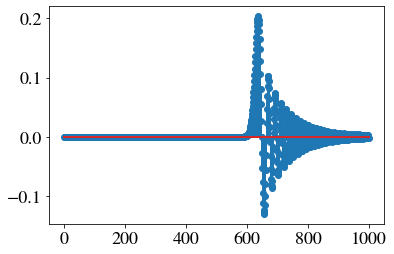

In [88]:
Δ = 0.1
r = smsv_r_from_stdev(Δ / np.sqrt(2))

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

x = 2 * 10 * np.sqrt(π)

plt.stem(X_gate(N, sqz_state, q=x).real)

Generate GKP data

In [4]:
%%time

N = 1000
grid_nmax = 10

num_peaks = 2 * grid_nmax + 1

num_points = 100  # for plotting
# num_points = 10 # for testing
# num_points = 2 # for desparate testing

# Delta=0.1 is nbar=50, Delta=1 is nbar=0.
Δs = np.geomspace(0.1, 1, num_points)

vacuum = fock_ket(N, 0)
data = []

for Δ in tqdm(Δs, desc="Δ"):
    r = smsv_r_from_stdev(Δ / np.sqrt(2))
    sqz_state = squeeze(N, vacuum, r=r, θ=0)

    ket = np.zeros(N, dtype=complex)

    for n in range(-grid_nmax, grid_nmax):
        # Gottesman+, Tzitrin+ window rather than Zhuang+
        x = 2 * n * np.sqrt(π)
        window = np.exp(-0.5 * Δ**2 * x**2)
        ket += window * X_gate(N, sqz_state, q=x)

    ket = normalise(N, ket)
    nbar0 = average_number(N, ket)
    var_x = variance(N, ket, x_quad(N))
    var_p = variance(N, ket, p_quad(N))
    window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)
    # print('state created')

    # lossless results
    settings = dict(
        N=N,
        σ=1e-3,
        δσ=1e-8,
        η=0,
        small_signal=True,
        loss_tol=1e-100,
    )
    construct_total_channel(settings)
    Fq_lossless = QFI_finite_difference(ket, settings)

    TMSV0_lossless = QFIM_TMSV(
        σ=settings["σ"], n=nbar0, η=1e-50, ηa=0, loss_type="input"
    )
    # print('lossless QFI calculated')

    # lossy results
    settings = dict(
        N=N,
        σ=1e-3,
        δσ=1e-8,
        η=1e-1,
        small_signal=True,
        loss_tol=1e-100,
    )
    construct_total_channel(settings)
    Fq = QFI_finite_difference(ket, settings)

    TMSV0 = QFIM_TMSV(
        σ=settings["σ"], n=nbar0, η=settings["η"], ηa=0, loss_type="input"
    )
    UB0 = lossy_UB_Tuvia(σ=settings["σ"], η_input=settings["η"], nbar=nbar0)
    # print('lossy QFI calculated')

    data.append(
        dict(
            QFI=Fq,
            nbar=nbar0,
            Δ=Δ,
            r=r,
            window_max=window_max,
            var_x=var_x,
            var_p=var_p,
            ratio_var_x_to_var_p=var_x / var_p,
            ratio_var_x_to_nbar=var_x / nbar0,
            ratio_ECQFI_UB=Fq / UB0,
            ECQFI_UB=UB0,
            ratio_TMSV=Fq / TMSV0,
            TMSV=TMSV0,
            QFI_lossless=Fq_lossless,
            ratio_TMSV_lossless=Fq_lossless / TMSV0_lossless,
            TMSV_lossless=TMSV0_lossless,
        )
    )

data = pd.DataFrame(data)

# no result after 5 min, 86% CPU usage and heating up, looks like a problem, let's move to OzStar?
# took 1 hr on Blackwater to do 10 points, see if it is faster on the HPC
# lossless case took 26 min on HPC to do 100 points, lossy case took 47 min to do 100 points

Δ:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

Save data

In [ ]:
file_tag = f"{num_peaks}_peaks_{N}_dim_{num_points}_points"
file = f"../data/GKP/QFI_vs_nbar---DeltaSqrt2_{file_tag}.txt"
data.to_csv(file, index=False)

In [ ]:
print(file)

../data/GKP/QFI_vs_nbar---DeltaSqrt2_21_peaks_1000_dim_100_points.txt


QFI       nbar         Δ             r     window_max      var_x  \
0   16.971867  49.501987  0.100000  2.302585e+00   1.867443e-03  50.003975   
1   16.851507  47.229759  0.102353  2.279327e+00   1.384572e-03  47.732096   
2   16.727320  45.060730  0.104762  2.256068e+00   1.012039e-03  45.563322   
3   16.599267  42.990245  0.107227  2.232810e+00   7.287817e-04  43.493041   
4   16.467307  41.013850  0.109750  2.209551e+00   5.166634e-04  41.516821   
..        ...        ...       ...           ...            ...        ...   
95   0.002447   0.008701  0.911163  9.303374e-02  2.845485e-227   0.417398   
96   0.003661   0.004871  0.932603  6.977531e-02  4.645211e-238   0.436760   
97   0.008355   0.002166  0.954548  4.651687e-02  2.323893e-249   0.457153   
98   0.045604   0.000562  0.977010  2.325844e-02  3.367685e-261   0.478591   
99   1.931687   0.000044  1.000000  1.110223e-16  1.332690e-273   0.501101   

        var_p  ratio_var_x_to_var_p  ratio_var_x_to_nbar  ratio_ECQFI_UB  \
0   49.999999              1.000080             1.010141        0.886788   
1   47.727422              1.000098             1.010636        0.882304   
2   45.558137              1.000114             1.011154        0.877679   
3   43.487450              1.000129             1.011696        0.872912   
4   41.510878              1.000143             1.012263        0.868001   
..        ...                   ...                  ...             ...   
95   0.600004              0.695658            47.971615        0.001036   
96   0.572981              0.762259            89.674097        0.001616   
97   0.547179              0.835473           211.077257        0.003844   
98   0.522533              0.915905           851.604434        0.021852   
99   0.498986              1.004239         11438.415334        0.954413   

     ECQFI_UB  ratio_TMSV       TMSV  QFI_lossless  ratio_TMSV_lossless  \
0   19.138585    0.999829  16.974774    200.029383             1.000207   
1   19.099430    0.999812  16.854669    190.940782             1.000209   
2   19.058580    0.999794  16.730772    182.267440             1.000226   
3   19.015972    0.999773  16.603041    173.982735             1.000212   
4   18.971539    0.999749  16.471442    166.075917             1.000207   
..        ...         ...        ...           ...                  ...   
95   2.361186    0.001214   2.015655      1.669592             0.820518   
96   2.265411    0.001823   2.008770      1.747041             0.865094   
97   2.173819    0.004170   2.003905      1.828613             0.910364   
98   2.086965    0.022790   2.001018      1.914364             0.956108   
99   2.023952    0.965802   2.000085      2.004407             1.002116   

    TMSV_lossless  
0      199.987947  
1      190.900813  
2      182.226315  
3      173.945852  
4      166.041613  
..            ...  
95       2.034802  
96       2.019480  
97       2.008661  
98       2.002246  
99       2.000173  

[100 rows x 16 columns]

Load data

In [9]:
# file_tag = f"{21}_peaks_{1000}_dim_{10}_points"
file_tag = f"{21}_peaks_{1000}_dim_{100}_points"
# pd.read_csv(f"../data/GKP/QFI_vs_nbar---DeltaSqrt2_{file_tag}.txt")
data = pd.read_csv(f"../data/GKP/QFI_vs_nbar---DeltaSqrt2_{file_tag}.txt")

Plot

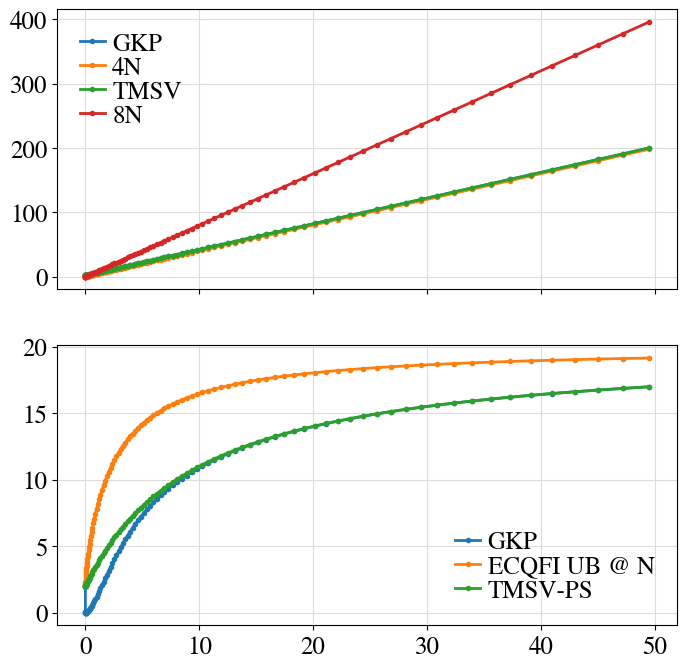

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

ax = axs[0]
ax.plot(data["nbar"], data["QFI_lossless"], ".-", label="GKP")
ax.plot(data["nbar"], 4 * data["nbar"], ".-", label="4N")
ax.plot(data["nbar"], data["TMSV_lossless"], ".-", label="TMSV")
ax.plot(data["nbar"], 8 * data["nbar"], ".-", label="8N")

ax = axs[1]
ax.plot(data["nbar"], data["QFI"], ".-", label="GKP")
ax.plot(data["nbar"], data["ECQFI_UB"], ".-", label="ECQFI UB @ N")
ax.plot(data["nbar"], data["TMSV"], ".-", label="TMSV-PS")

for ax in axs:
    grid(ax)
    legend(ax)

plt.show()

### Jeff: QFI up to $50  = \bar n$ with RHS bug fixed

In [13]:
N = 1000
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1
print(num_peaks, "peaks")

21 peaks


<StemContainer object of 3 artists>

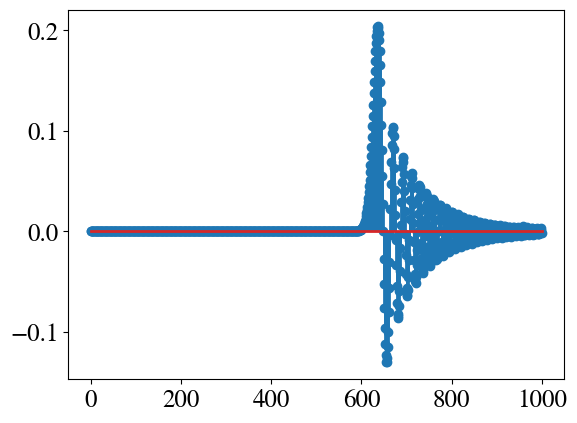

In [6]:
Δ = 0.1
r = smsv_r_from_stdev(Δ / np.sqrt(2))

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

x = 2 * 10 * np.sqrt(π)

plt.stem(X_gate(N, sqz_state, q=x).real)

Generate GKP data

In [7]:
%%time

N = 1000
grid_nmax = 10

num_peaks = 2 * grid_nmax + 1

num_points = 100  # for plotting
# num_points = 10 # for testing
# num_points = 2 # for desparate testing

# Delta=0.1 is nbar=50, Delta=1 is nbar=0.
Δs = np.geomspace(0.1, 1, num_points)

vacuum = fock_ket(N, 0)
data = []

for Δ in tqdm(Δs, desc="Δ"):
    r = smsv_r_from_stdev(Δ / np.sqrt(2))
    sqz_state = squeeze(N, vacuum, r=r, θ=0)

    ket = np.zeros(N, dtype=complex)

    # Change to +1 on the RHS to include the last peak thanks to Jeff Wack
    for n in range(-grid_nmax, grid_nmax + 1):
        # Gottesman+, Tzitrin+ window rather than Zhuang+
        x = 2 * n * np.sqrt(π)
        window = np.exp(-0.5 * Δ**2 * x**2)
        ket += window * X_gate(N, sqz_state, q=x)

    ket = normalise(N, ket)
    nbar0 = average_number(N, ket)
    var_x = variance(N, ket, x_quad(N))
    var_p = variance(N, ket, p_quad(N))
    window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)
    # print('state created')

    # lossless results
    settings = dict(
        N=N,
        σ=1e-3,
        δσ=1e-8,
        η=0,
        small_signal=True,
        loss_tol=1e-100,
    )
    construct_total_channel(settings)
    Fq_lossless = QFI_finite_difference(ket, settings)

    TMSV0_lossless = QFIM_TMSV(
        σ=settings["σ"], n=nbar0, η=1e-50, ηa=0, loss_type="input"
    )
    # print('lossless QFI calculated')

    # lossy results
    settings = dict(
        N=N,
        σ=1e-3,
        δσ=1e-8,
        η=1e-1,
        small_signal=True,
        loss_tol=1e-100,
    )
    construct_total_channel(settings)
    Fq = QFI_finite_difference(ket, settings)

    TMSV0 = QFIM_TMSV(
        σ=settings["σ"], n=nbar0, η=settings["η"], ηa=0, loss_type="input"
    )
    UB0 = lossy_UB_Tuvia(σ=settings["σ"], η_input=settings["η"], nbar=nbar0)
    # print('lossy QFI calculated')

    data.append(
        dict(
            QFI=Fq,
            nbar=nbar0,
            Δ=Δ,
            r=r,
            window_max=window_max,
            var_x=var_x,
            var_p=var_p,
            ratio_var_x_to_var_p=var_x / var_p,
            ratio_var_x_to_nbar=var_x / nbar0,
            ratio_ECQFI_UB=Fq / UB0,
            ECQFI_UB=UB0,
            ratio_TMSV=Fq / TMSV0,
            TMSV=TMSV0,
            QFI_lossless=Fq_lossless,
            ratio_TMSV_lossless=Fq_lossless / TMSV0_lossless,
            TMSV_lossless=TMSV0_lossless,
        )
    )

data = pd.DataFrame(data)

# no result after 5 min, 86% CPU usage and heating up, looks like a problem, let's move to OzStar?
# took 1 hr on Blackwater to do 10 points, see if it is faster on the HPC
# lossless case took 26 min on HPC to do 100 points, lossy case took 47 min to do 100 points

Δ:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

Save data

In [ ]:
file_tag = f"{num_peaks}_peaks_{N}_dim_{num_points}_points_Fixed"
file = f"../data/GKP/QFI_vs_nbar---DeltaSqrt2_{file_tag}.txt"
data.to_csv(file, index=False)

In [ ]:
print(file)

../data/GKP/QFI_vs_nbar---DeltaSqrt2_21_peaks_1000_dim_100_points.txt


QFI       nbar         Δ             r     window_max      var_x  \
0   16.971867  49.501987  0.100000  2.302585e+00   1.867443e-03  50.003975   
1   16.851507  47.229759  0.102353  2.279327e+00   1.384572e-03  47.732096   
2   16.727320  45.060730  0.104762  2.256068e+00   1.012039e-03  45.563322   
3   16.599267  42.990245  0.107227  2.232810e+00   7.287817e-04  43.493041   
4   16.467307  41.013850  0.109750  2.209551e+00   5.166634e-04  41.516821   
..        ...        ...       ...           ...            ...        ...   
95   0.002447   0.008701  0.911163  9.303374e-02  2.845485e-227   0.417398   
96   0.003661   0.004871  0.932603  6.977531e-02  4.645211e-238   0.436760   
97   0.008355   0.002166  0.954548  4.651687e-02  2.323893e-249   0.457153   
98   0.045604   0.000562  0.977010  2.325844e-02  3.367685e-261   0.478591   
99   1.931687   0.000044  1.000000  1.110223e-16  1.332690e-273   0.501101   

        var_p  ratio_var_x_to_var_p  ratio_var_x_to_nbar  ratio_ECQFI_UB  \
0   49.999999              1.000080             1.010141        0.886788   
1   47.727422              1.000098             1.010636        0.882304   
2   45.558137              1.000114             1.011154        0.877679   
3   43.487450              1.000129             1.011696        0.872912   
4   41.510878              1.000143             1.012263        0.868001   
..        ...                   ...                  ...             ...   
95   0.600004              0.695658            47.971615        0.001036   
96   0.572981              0.762259            89.674097        0.001616   
97   0.547179              0.835473           211.077257        0.003844   
98   0.522533              0.915905           851.604434        0.021852   
99   0.498986              1.004239         11438.415334        0.954413   

     ECQFI_UB  ratio_TMSV       TMSV  QFI_lossless  ratio_TMSV_lossless  \
0   19.138585    0.999829  16.974774    200.029383             1.000207   
1   19.099430    0.999812  16.854669    190.940782             1.000209   
2   19.058580    0.999794  16.730772    182.267440             1.000226   
3   19.015972    0.999773  16.603041    173.982735             1.000212   
4   18.971539    0.999749  16.471442    166.075917             1.000207   
..        ...         ...        ...           ...                  ...   
95   2.361186    0.001214   2.015655      1.669592             0.820518   
96   2.265411    0.001823   2.008770      1.747041             0.865094   
97   2.173819    0.004170   2.003905      1.828613             0.910364   
98   2.086965    0.022790   2.001018      1.914364             0.956108   
99   2.023952    0.965802   2.000085      2.004407             1.002116   

    TMSV_lossless  
0      199.987947  
1      190.900813  
2      182.226315  
3      173.945852  
4      166.041613  
..            ...  
95       2.034802  
96       2.019480  
97       2.008661  
98       2.002246  
99       2.000173  

[100 rows x 16 columns]

Load data

In [8]:
file_tag = f"{21}_peaks_{1000}_dim_{10}_points_Fixed"
pd.read_csv(f"../data/GKP/QFI_vs_nbar---DeltaSqrt2_{file_tag}.txt")
# data = pd.read_csv(f"../data/GKP/QFI_vs_nbar---DeltaSqrt2_{file_tag}.txt")

QFI       nbar         Δ             r     window_max      var_x  \
0  16.971867  49.501987  0.100000  2.302585e+00   1.867443e-03  50.003975   
1  15.432161  29.478383  0.129155  2.046742e+00   2.806507e-05  29.982553   
2  13.419129  17.476025  0.166810  1.790900e+00   2.553192e-08  17.982981   
3  11.006539  10.283761  0.215443  1.535057e+00   2.158996e-13  10.795349   
4   8.283551   5.971954  0.278256  1.279214e+00   7.451759e-22   6.486160   
5   5.203124   3.296475  0.359381  1.023371e+00   5.712202e-36   3.721632   
6   2.055975   1.454757  0.464159  7.675284e-01   1.624819e-59   1.588748   
7   0.324198   0.419213  0.599484  5.116856e-01   8.584447e-99   0.448737   
8   0.013938   0.072238  0.774264  2.558428e-01  2.603592e-164   0.314703   
9   1.931687   0.000044  1.000000  1.110223e-16  1.332690e-273   0.501101   

       var_p  ratio_var_x_to_var_p  ratio_var_x_to_nbar  ratio_ECQFI_UB  \
0  49.999999              1.000080             1.010141        0.886788   
1  29.974213              1.000278             1.017103        0.829532   
2  17.969068              1.000774             1.029009        0.754961   
3  10.772173              1.002151             1.049747        0.665218   
4   6.457748              1.004400             1.086103        0.558388   
5   3.871318              0.961334             1.128973        0.415016   
6   2.320766              0.684579             1.092105        0.223127   
7   1.389689              0.322905             1.070428        0.059359   
8   0.829773              0.379264             4.356485        0.004384   
9   0.498986              1.004239         11438.415334        0.954413   

    ECQFI_UB  ratio_TMSV       TMSV  QFI_lossless  ratio_TMSV_lossless  \
0  19.138585    0.999829  16.974774    200.029945             1.000210   
1  18.603452    0.999462  15.440462    119.937707             1.000262   
2  17.774603    0.997794  13.448793     71.934327             1.000456   
3  16.545754    0.989272  11.125899     43.182300             1.001117   
4  14.834768    0.948832   8.730261     25.944808             1.002214   
5  12.537161    0.805113   6.462601     14.886583             0.980297   
6   9.214391    0.479693   4.286024      6.355001             0.812764   
7   5.461685    0.119005   2.724235      1.794950             0.488177   
8   3.179286    0.006547   2.129104      1.258813             0.549953   
9   2.023952    0.965802   2.000085      2.004407             1.002116   

   TMSV_lossless  
0     199.987947  
1     119.906341  
2      71.901514  
3      43.134114  
4      25.887481  
5      15.185785  
6       7.818996  
7       3.676846  
8       2.288949  
9       2.000173

Plot

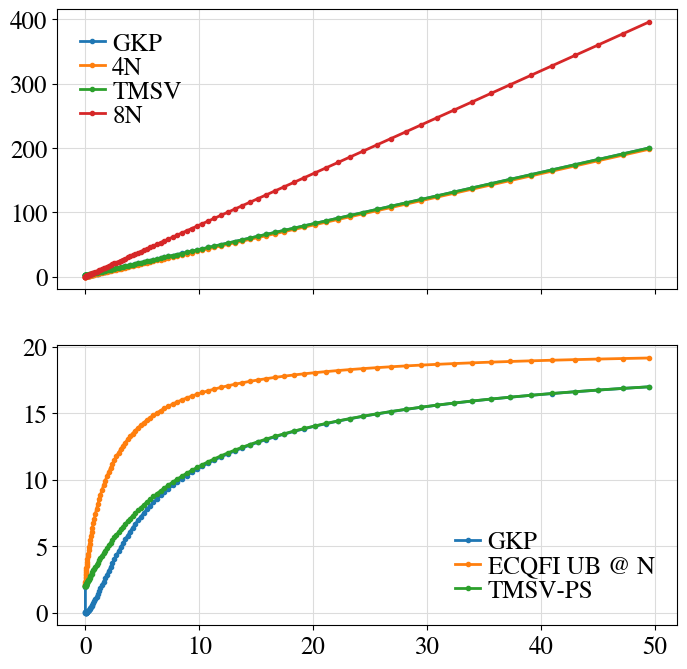

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

ax = axs[0]
ax.plot(data["nbar"], data["QFI_lossless"], ".-", label="GKP")
ax.plot(data["nbar"], 4 * data["nbar"], ".-", label="4N")
ax.plot(data["nbar"], data["TMSV_lossless"], ".-", label="TMSV")
ax.plot(data["nbar"], 8 * data["nbar"], ".-", label="8N")

ax = axs[1]
ax.plot(data["nbar"], data["QFI"], ".-", label="GKP")
ax.plot(data["nbar"], data["ECQFI_UB"], ".-", label="ECQFI UB @ N")
ax.plot(data["nbar"], data["TMSV"], ".-", label="TMSV-PS")

for ax in axs:
    grid(ax)
    legend(ax)

plt.show()